In [3]:
modelFolder = '../SiameseOld/arch_17_wn_2/'
datasetFolder = '../Datasets/IITD/2D/'

Opening DB ../SiameseOld/arch_17_wn_2//model.hdf5
Creating network ...
Building network ... Done.
Network:
	Input dimensions (D x W x H): 1 x 128 x 128
	Number of outputs: 48
Compiling functions ... Done.
Available functions:
	'test'
	'train'
	'features'
Plotting conv layer filters ...


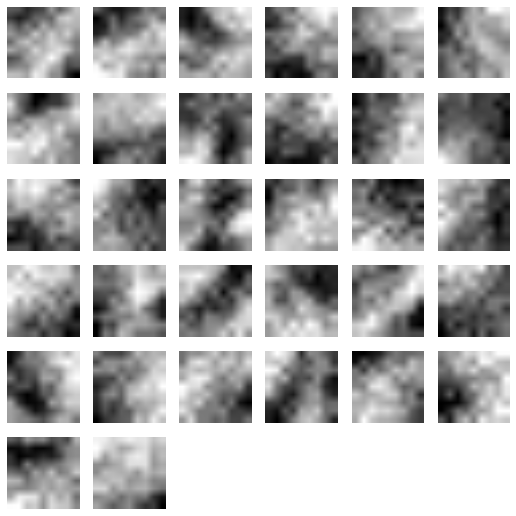

In [4]:
%matplotlib inline
import Evaluation.conv_filters as filters
import matplotlib.pyplot as plt

filters.plot_conv_filters(modelFolder + '/model.hdf5', 'conv1', epoch = 400)

In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test = datasets.loadAnnotatedHands2('../Datasets/Annotated/',
    normalize = False, verbose = False)
    
inputImg = X_train[10].reshape(1, X_train[10].shape[0], X_train[10].shape[1], X_train[10].shape[2])
inputImg = inputImg.astype(np.float32)
inputImg = inputImg[0]
inputImg = inputImg.reshape(inputImg.shape[1], inputImg.shape[2], inputImg.shape[0])
inputImg = inputImg[:, :, 1]
inputImg[inputImg < 25] = 0
inputImg[inputImg > 25] = 255

plt.imshow(inputImg)


In [ ]:
%matplotlib inline
import sys
sys.path.append('../LandmarkDetection/')
import Utils.datasets as datasets
import Utils.visualization as visualization
import Utils.snapshotter as snapshotter
import Utils.augmentation as dataAugmentation
import Utils.tests as tests
import Models.network as network
import lasagne
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

# Load configurations
print('Loading settings ...')
persistentDb = snapshotter.Snapshotter(modelFolder + '/model.hdf5')
networkCfg = persistentDb.load('config_network')
testingCfg = persistentDb.load('config_testing')

# Get network model
print('Creating network ...')
cnnetwork, cnnlayers, functions = network.getModel(networkCfg)

# Load the dataset
print('Loading dataset ...')
X_train, y_train, X_val, y_val, X_test, y_test = datasets.loadAnnotatedHands2('../Datasets/Annotated/',
    normalize = False, verbose = False)
    
epochId = 500
print('Params from epoch: {0}'.format(epochId))
modelParamsKey = 'Epoch_%05i_params' % epochId
modelParams = persistentDb.load(modelParamsKey)

# Load model parameters
print('Setting network parameters ...')
lasagne.layers.set_all_param_values(cnnetwork, modelParams)

inputImg = X_train[10].reshape(1, X_train[10].shape[0], X_train[10].shape[1], X_train[10].shape[2])
inputImg = inputImg.astype(np.float32)
tgtLmks = y_train[10]
tgtLmks = tgtLmks.astype(np.float32)
print(inputImg.shape)
print(tgtLmks.shape)
lmks = functions['features'](inputImg)
lmks = lmks[0]
print(tgtLmks)
print(lmks)

plt.imshow(inputImg[0].reshape(inputImg[0].shape[1], inputImg[0].shape[2], inputImg[0].shape[0]))
for i in range(len(lmks) / 2):
    plt.plot([lmks[i + 1]], [lmks[i]], 'ro')

'''
sns.set_style('dark')
figs, axes = plt.subplots(1, 2)
axes[0].imshow(X_test[idx1][0], cmap = 'gray')
axes[0].set_xlabel('Score: ' + str(score))
axes[1].imshow(X_test[idx2][0], cmap = 'gray')
axes[1].set_xlabel('Ground truth: ' + str(lbl))
'''

In [ ]:
%matplotlib inline
import sys
sys.path.append('../MulticlassFullHands/')
import Utils.datasets as datasets
import Utils.visualization as visualization
import Utils.snapshotter as snapshotter
import Utils.augmentation as dataAugmentation
import Utils.tests as tests
import Models.network as network
import lasagne
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

# Load configurations
print('Loading settings ...')
persistentDb = snapshotter.Snapshotter(modelFolder + '/model.hdf5')
targetDim = (128, 128) #(persistentDb.load('network_inputWidth'),
    #persistentDb.load('network_inputHeight'))
networkCfg = persistentDb.load('config_network')
#networkCfg['inputWidth'] = 120
#networkCfg['inputHeight'] = 120
testingCfg = persistentDb.load('config_testing')

# Get network model
print('Creating network ...')
cnnetwork, cnnlayers, functions = network.getModel(networkCfg)

# Load the dataset
print('Loading dataset ...')
X_train, y_train, X_val, y_val, X_test, y_test = datasets.loadDatasetIITD(datasetFolder,
    targetDim = targetDim, verbose = False, normalize = False)
    
epochId = 50#persistentDb.load('training_numEpochs')
print('Params from epoch: {0}'.format(epochId))
modelParamsKey = 'Epoch_%05i_params' % epochId
modelParams = persistentDb.load(modelParamsKey)

# Load model parameters
print('Setting network parameters ...')
lasagne.layers.set_all_param_values(cnnetwork, modelParams)

def shift(image, size = 8, step = 1):
    # List of new images
    newImages = list()
    # Resulting image size
    half = size / 2
    for yy in range(0, size, step):
            for xx in range(0, size, step):
                    sx = yy - half
                    sy = xx - half
                    newImg = np.roll(image[0], sy, axis = 0)
                    newImg = np.roll(newImg, sx, axis = 1)
                    newImages.append(newImg.reshape(1, newImg.shape[0], newImg.shape[1]))

    return newImages

idx1 = 18
idx2 = 19
probe = X_test[idx1]
ref = X_test[idx2]
probes = shift(probe, size = 8, step = 1)
scores = []
for aProbe in probes:
    couple = np.array([aProbe, ref])
    scores.append(functions['score'](np.array([couple.reshape(2, couple.shape[2], couple.shape[3])])))
score = np.min(np.array(scores))
lbl = int(y_test[idx1] == y_test[idx2])
    
sns.set_style('dark')
figs, axes = plt.subplots(1, 2)
axes[0].imshow(X_test[idx1][0], cmap = 'gray')
axes[0].set_xlabel('Score: ' + str(score))
axes[1].imshow(X_test[idx2][0], cmap = 'gray')
axes[1].set_xlabel('Ground truth: ' + str(lbl))


In [ ]:
%matplotlib inline
import csv
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import Utils.datasets as datasets
    
# Load the dataset
print('Loading dataset ...')
targetDim = (150, 150)
X_train, y_train, X_val, y_val, X_test, y_test = datasets.loadDatasetIITD(datasetFolder,
    targetDim = targetDim, verbose = False)
    
# Load the error sample indices
print('Loading error records ...')
i = 521
with open(modelFolder + '/errors' + str(i) + '.csv') as f:
    reader = csv.reader(f)
    errorSamples = np.array(map(float, list(reader)[0]))

# Show errors
cntr = 0
print(len(errorSamples) / 4)
for idx in range(len(errorSamples) / 3):
    idx1 = errorSamples[idx * 4]
    idx2 = errorSamples[idx * 4 + 1]
    lbl = errorSamples[idx * 4 + 2]
    score = errorSamples[idx * 4 + 3]
    if(lbl == 1):
        cntr = cntr + 1
        if cntr > 20:
            break
        print('{} {} {} {}'.format(idx1, idx2, lbl, score))

        sns.set_style('dark')
        figs, axes = plt.subplots(1, 2)
        axes[0].imshow(X_test[idx1][0], cmap = 'gray')
        axes[0].set_xlabel('Score: ' + str(score))
        axes[1].imshow(X_test[idx2][0], cmap = 'gray')
        axes[1].set_xlabel('Ground truth: ' + str(lbl))

plt.show()

In [ ]:
%matplotlib inline
import Evaluation.roc_curve2 as roc
import csv
import numpy as np
import matplotlib.pyplot as plt
    
for i in [0]:
    with open(modelFolder + '/scoresPos' + str(i) + '_1.csv') as f:
        reader = csv.reader(f)
        genuine = np.array(map(float, list(reader)[0]))
    with open(modelFolder + '/scoresNeg' + str(i) + '_2.csv') as f:
        reader = csv.reader(f)
        impostor = np.array(map(float, list(reader)[0]))
    
    fars, frrs, eer = roc.roc_curve(genuine, impostor, str(i) + ' Tepochs')
    print('EER({}): {:.3f}%'.format(i, eer * 100))

plt.show()

In [ ]:
%matplotlib inline
import csv
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

for i in [1, 207]:
    genuine = []
    impostor = []
    for j in range(samplesPerClass):
        with open(modelFolder + '/scoresPos' + str(i) + '_' + str(j + 1) + '.csv') as f:
            reader = csv.reader(f)
            genuine.extend(map(float, list(reader)[0]))
        with open(modelFolder + '/scoresNeg' + str(i) + '_' + str(j + 1) + '.csv') as f:
            reader = csv.reader(f)
            impostor.extend(map(float, list(reader)[0]))
    genuine = np.array(genuine)
    impostor = np.array(impostor)
        
    gpdf = sns.distplot(genuine, hist = False, color = 'g', kde_kws = {'shade': True}, label = 'genuine')
    ipdf = sns.distplot(impostor, hist = False, color = 'r', kde_kws = {'shade': True}, label = 'impostor')

    plt.legend(loc = 'upper right')
    plt.xlabel('Matching score')
    plt.ylabel('PDF')
    plt.show()

In [ ]:
%matplotlib inline
import sys
sys.path.append('../Classifier/')
#sys.path.append('../Siamese/')
import Utils.datasets as datasets
import Utils.visualization as visualization
import Utils.snapshotter as snapshotter
import Utils.augmentation as dataAugmentation
import Utils.tests as tests
import Models.network as network
import lasagne
import numpy as np
import os

# Load configurations
print('Loading settings ...')
persistentDb = snapshotter.Snapshotter(modelFolder + '/model.hdf5')
targetDim = (150, 150) #(persistentDb.load('network_inputWidth'),
    #persistentDb.load('network_inputHeight'))
networkCfg = persistentDb.load('config_network')
#networkCfg['inputWidth'] = 120
#networkCfg['inputHeight'] = 120
testingCfg = persistentDb.load('config_testing')

# Get network model
print('Creating network ...')
cnnetwork, cnnlayers, functions = network.getModel(networkCfg)

# Load the dataset
print('Loading dataset ...')
X_train, y_train, X_val, y_val, X_test, y_test = datasets.loadDatasetIITD(datasetFolder,
    targetDim = targetDim, verbose = False)
    
epochIds = [50]#persistentDb.load('training_numEpochs')
for epochId in epochIds:
    print('Results at epoch: {0}'.format(epochId))
    modelParamsKey = 'Epoch_%05i_params' % epochId
    modelParams = persistentDb.load(modelParamsKey)

    # Load model parameters
    print('Setting network parameters ...')
    lasagne.layers.set_all_param_values(cnnetwork, modelParams)

    # Generate leave-one-out tests
    testData = dict()
    testData['data'] = dataAugmentation.cropVec(X_train)
    testData['labels'] = y_train
    scores, labels = tests.compareAllCouples(functions['score'], testingCfg, testData)
    scoresPos = []
    scoresNeg = []
    numErrors = 0
    print('Evaluating all {0} scores ...'.format(len(scores)))
    for idx in range(len(scores)):
        print('Score {0} of {1}'.format(idx, len(scores)))
        if labels[idx] == 0:
            scoresNeg.append(scores[idx])
        else:
            scoresPos.append(scores[idx])
            
        if int(scores[idx] > 0.5) != labels[idx]:
            numErrors += 1
    
    print('\tErrors: {0}/{1}'.format(numErrors, len(scores)))
    # Save pos and neg scores
    filePos = open(os.path.join(modelFolder, 'scoresPos' + str(epochId) + '.csv'), 'w')
    filePos.write(str(scoresPos[0]))
    for score in scoresPos[1:]:
        filePos.write(', ' + str(score))
    filePos.write('\n')
    filePos.close()
    fileNeg = open(os.path.join(modelFolder, 'scoresNeg' + str(epochId) + '.csv'), 'w')
    fileNeg.write(str(scoresNeg[0]))
    for score in scoresNeg[1:]:
        fileNeg.write(', ' + str(score))
    fileNeg.write('\n')
    fileNeg.close()

persistentDb.close()



In [ ]:
%matplotlib inline
import Evaluation.saliency as saliency

saliency.plot_saliency_map(modelFolder + '/model.hdf5', datasetFolder + '001_1.bmp')

In [ ]:
%matplotlib inline
import Evaluation.conv_filters as filters
import matplotlib.pyplot as plt

filters.plot_conv_filters(modelFolder + '/model.hdf5', 'conv1', epoch = 100)

In [ ]:
# Local image normalization test
#datasetFolder = '../Casia_Filt/Merged/'
%matplotlib inline
import os
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import filters
from skimage import morphology
from skimage.restoration import denoise_tv_chambolle, denoise_bilateral

def localNormalize(img, mean, std, eps = 0.1):                                                                                                            
        meanVals = sp.ndimage.gaussian_filter(img, mean)                                                                                       
        imgCent = img - meanVals                                                                                                               
        stdVals = np.sqrt(sp.ndimage.gaussian_filter(imgCent**2, std))                                                                         
        return imgCent / (stdVals + eps)               

#img = sp.misc.imread(os.path.join('../Datasets/IITD/2D/', '218_5.bmp')) 
img = sp.misc.imread(os.path.join('../Datasets/HKPoly/2D/130_F/', '02.bmp')) 
#img = sp.misc.imread(os.path.join(datasetFolder, '0001_01.jpg')) 
#img = sp.misc.imresize(img, (150, 150))
img = img / np.float32(256)                                                                                                            
plt.imshow(img)
plt.set_cmap('gray')
plt.colorbar()
plt.figure()
imgg = localNormalize(np.copy(img), 5, 15, eps = 0.1) 
sns.set_style('dark')
plt.imshow(imgg)
plt.set_cmap('gray')
plt.colorbar()
plt.figure()
imgg = localNormalize(np.copy(img), 5, 15, eps = 1.0)  
imgg = denoise_tv_chambolle(imgg, weight = 0.05) 
sns.set_style('dark')
plt.imshow(imgg)
plt.set_cmap('gray')
plt.colorbar()

In [ ]:
%matplotlib inline
import Utils.augmentation as dataAugmentation
import Utils.datasets as datasets
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import filters
from skimage import morphology
from skimage.restoration import denoise_tv_chambolle, denoise_bilateral

targetDim = (150, 150)
X_train, y_train, X_val, y_val, X_test, y_test = datasets.loadDatasetIITD(datasetFolder,
    targetDim = targetDim, verbose = False)
img = X_test[0]

maxv = np.max(img[0])
minv = np.min(img[0])
img[0] = (img[0] - minv) / (maxv - minv)

sns.set_style('dark')
plt.figure()

#img = denoise_tv_chambolle(img, weight = 0.1)
plt.figure()
plt.imshow(img[0])
plt.figure()
plt.imshow(img[0, 0:64, 0:64])
plt.figure()
plt.imshow(img[0, 64:128, 0:64])
plt.figure()
plt.imshow(img[0, 0:64, 64:128])
plt.figure()
plt.imshow(img[0, 64:128, 64:128])
plt.figure()
plt.imshow(img[0, 32:96, 32:96])

'''
for i in range(10):
    imgr = dataAugmentation.rotateInPlace(img)
    plt.figure()
    sns.set_style('dark')
    plt.imshow(imgr[0, :, :])
'''


In [ ]:
%matplotlib inline
import Utils.augmentation as dataAugmentation
import Utils.datasets as datasets
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import filters
from skimage import morphology
from skimage.restoration import denoise_tv_chambolle, denoise_bilateral
from scipy.ndimage.interpolation import affine_transform

targetDim = (150, 150)
X_train, y_train, X_val, y_val, X_test, y_test = datasets.loadDatasetIITD(datasetFolder,
    targetDim = targetDim, verbose = False, normalize = False)
img = X_test[0]
s1, s2 = ((np.random.random(2) * 2.0) - 1.0) / 5.0
r1, r2 = ((np.random.random(2) * 2.0) - 1.0) / 5.0
t1, t2 = ((np.random.random(2) * 14.0) - 7.0)

A = np.array([[1.0 + s1, r2, t1], [r1, 1.0 + s2, t2], [0, 0, 1]])
img = affine_transform(img[0], A[:2, :2], (A[0, 2], A[1, 2]))

sns.set_style('dark')
plt.figure()

plt.imshow(img)
plt.set_cmap('gray')
plt.colorbar()


In [ ]:
%matplotlib inline
import sys
sys.path.append('../Classifier/')
#sys.path.append('../Siamese/')
import Utils.datasets as datasets
import Utils.visualization as visualization
import Utils.snapshotter as snapshotter
import Utils.augmentation as dataAugmentation
import Utils.tests as tests
import Models.network as network
import lasagne
import numpy as np
import os

# Load configurations
print('Loading settings ...')
persistentDb = snapshotter.Snapshotter(modelFolder + '/model.hdf5')
targetDim = (150, 150) #(persistentDb.load('network_inputWidth'),
    #persistentDb.load('network_inputHeight'))
networkCfg = persistentDb.load('config_network')
#networkCfg['inputWidth'] = 120
#networkCfg['inputHeight'] = 120
testingCfg = persistentDb.load('config_testing')

# Get network model
print('Creating network ...')
cnnetwork, cnnlayers, functions = network.getModel(networkCfg)

# Load the dataset
print('Loading dataset ...')
#X_train, y_train, X_val, y_val, X_test, y_test = datasets.loadDatasetIITD(datasetFolder,
#    targetDim = targetDim, verbose = False)
X_test, y_test = datasets.loadDatasetCasia2(datasetFolder,
    targetDim = targetDim, verbose = False)
    
epochIds = [500]#persistentDb.load('training_numEpochs')
for epochId in epochIds:
    print('Results at epoch: {0}'.format(epochId))
    modelParamsKey = 'Epoch_%05i_params' % epochId
    modelParams = persistentDb.load(modelParamsKey)

    # Load model parameters
    print('Setting network parameters ...')
    lasagne.layers.set_all_param_values(cnnetwork, modelParams)

    # Generate leave-one-out tests
    testData = dict()
    testData['data'] = X_test
    testData['labels'] = y_test
    testRuns = tests.genLeaveOneOutClassif(testingCfg, testData, numClassSamples = 3)
    idx = 0
    for aRun in tests.testLeaveOneOutClassif(functions['score'], testRuns, testData['data']):
        idx += 1
        print('Test run {} of {}:'.format(idx, len(testRuns)))
        scoresPos, scoresNeg, results = aRun
        numErrors = 0
        for res in results:
            score, lbl1, lbl2 = res[0], res[1], res[2]
            if lbl1 != lbl2:
                numErrors += 1
        print('\tErrors: {0}/{1}'.format(numErrors, len(results)))
        # Save pos and neg scores
        filePos = open(os.path.join(modelFolder, 'scoresPos' + str(epochId) + '.csv'), 'w')
        filePos.write(str(scoresPos[0]))
        for score in scoresPos[1:]:
            filePos.write(', ' + str(score))
        filePos.write('\n')
        filePos.close()
        fileNeg = open(os.path.join(modelFolder, 'scoresNeg' + str(epochId) + '.csv'), 'w')
        fileNeg.write(str(scoresNeg[0]))
        for score in scoresNeg[1:]:
            fileNeg.write(', ' + str(score))
        fileNeg.write('\n')
        fileNeg.close()

persistentDb.close()
